In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

### **Dataset Configuration**

- **`train_path = 'crop dataset'`** → Specifies the folder containing training images, organized into subfolders by class.  
- **`val_path = 'crop dataset'`** → Specifies the folder for validation images, structured similarly to training data.  
- **`image_size = (224, 224)`** → Defines the input image dimensions required by MobileNet.  
- **`batch_size = 32`** → Number of images processed in each training step (batch).

In [ ]:
train_path = 'crop dataset' 
val_path = 'crop dataset'    
image_size = (224, 224)      
batch_size = 32


### **Data Preprocessing and Augmentation**

- **Data Augmentation for Training (`train_datagen`)** → Enhances the training dataset by applying transformations (scaling, rotation, shifting, shearing, zooming, flipping) to improve model generalization.  
- **Rescaling for Validation (`val_datagen`)** → Only normalizes pixel values (1.0/255.0) without augmentation.  
- **Loading Training Data (`train_generator`)** → Loads and processes training images from directories, applying augmentation and resizing.  
- **Loading Validation Data (`val_generator`)** → Loads and processes validation images with only rescaling and resizing.

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  
)


Found 36496 images belonging to 26 classes.
Found 36496 images belonging to 26 classes.


### **Model Building and Compilation**

- **Load MobileNet (`base_model`)** → Uses a pre-trained MobileNet model (without the top layers) as the feature extractor.  
- **Freeze Base Model Layers** → Prevents updating MobileNet's pretrained weights during training.  
- **Add Custom Layers** → Introduces new layers (GlobalAveragePooling, Dense layers) for classification, with 26 output classes.  
- **Define Model (`model`)** → Connects MobileNet’s input to the newly added classification layers.  
- **Compile Model (`model.compile`)** → Sets the optimizer (Adam), loss function (categorical cross-entropy), and evaluation metric (accuracy).  
- **Print Model Summary (`model.summary()`)** → Displays the architecture and layer details.

In [ ]:

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(26, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,816,602 (18.37 MB)

 Trainable params: 1,587,738 (6.06 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

### **Model Training**

- **Set Epochs (`epochs = 10`)** → Defines the number of times the model will go through the entire dataset during training.  
- **Train the Model (`model.fit`)** →  
  - Uses `train_generator` for training data.  
  - Runs for `epochs=10`.  
  - Validates using `val_generator` after each epoch.  
  - Stores training history (accuracy, loss, etc.) in `history` for visualization and evaluation.

In [5]:
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/10


C:\Users\thanuj123\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1795s 2s/step - accuracy: 0.7303 - loss: 0.9281 - val_accuracy: 0.9102 - val_loss: 0.2707
Epoch 2/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1489s 1s/step - accuracy: 0.9018 - loss: 0.2913 - val_accuracy: 0.9135 - val_loss: 0.2470
Epoch 3/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1522s 1s/step - accuracy: 0.9208 - loss: 0.2330 - val_accuracy: 0.9444 - val_loss: 0.1617
Epoch 4/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1277s 1s/step - accuracy: 0.9289 - loss: 0.2027 - val_accuracy: 0.9432 - val_loss: 0.1635
Epoch 5/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1349s 1s/step - accuracy: 0.9330 - loss: 0.1887 - val_accuracy: 0.9517 - val_loss: 0.1383
Epoch 6/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1360s 1s/step - accuracy: 0.9409 - loss: 0.1666 - val_accuracy: 0.9568 - val_loss: 0.1248
Epoch 7/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1545s 1s/step - accuracy: 0.9450 - loss: 0.1494 - val_accuracy: 0.9555 - val_loss: 0.1215
Epoch 8/10
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 1321s 1s/step - accuracy: 0.9519 - loss: 0.13

### **Model Evaluation and Visualization**  

- **Plot Accuracy & Loss**  
  - **Accuracy Plot** → Displays training and validation accuracy over epochs.  
  - **Loss Plot** → Shows how the training and validation loss change over epochs.  
  - Uses `plt.subplot()` for side-by-side visualization.  

- **Evaluate Model (`model.evaluate`)**  
  - Tests the model on validation data and prints the final validation accuracy.  

- **Save Model (`model.save`)**  
  - Saves the trained model as `'crop_disease_detection_mobilenet.h5'` for future use.

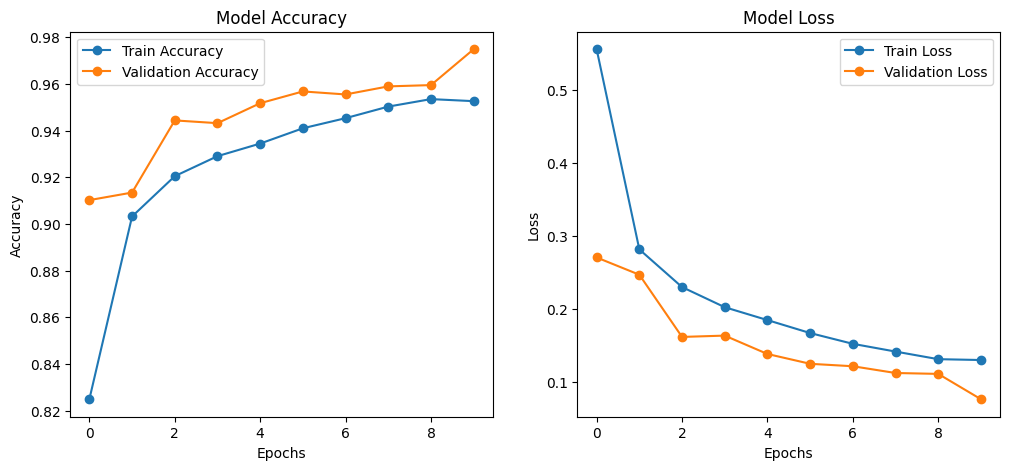

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 550s 482ms/step - accuracy: 0.9739 - loss: 0.0764


Validation Accuracy: 0.97


In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

model.save('crop_disease_detection_mobilenet.h5')

### **Explanation of Each Layer in the MobileNet Model for Plant Disease Classification**  

1. **Convolutional Layers (Conv2D)**:  
   - Extract important features such as **edges, textures, and patterns** from the input image.  
   - Early layers detect simple features, while deeper layers capture more complex structures like **disease spots and leaf patterns**.  

2. **Pooling Layers (MaxPooling2D)**:  
   - Reduce the spatial dimensions of feature maps while **preserving essential features**.  
   - Helps in making the model more **computationally efficient** and reduces overfitting.  

3. **Flatten Layer**:  
   - Converts the multi-dimensional feature maps into a **one-dimensional vector**.  
   - This allows the extracted features to be passed to the fully connected layers for classification.  

4. **Fully Connected Layers (Dense)**:  
   - Perform **final classification** by learning patterns from the extracted features.  
   - Assigns the image to a **specific disease category** based on learned features.

Using image: Untitled.jpg


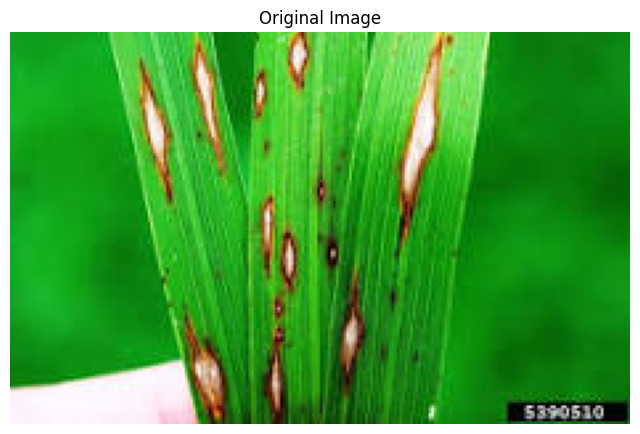

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


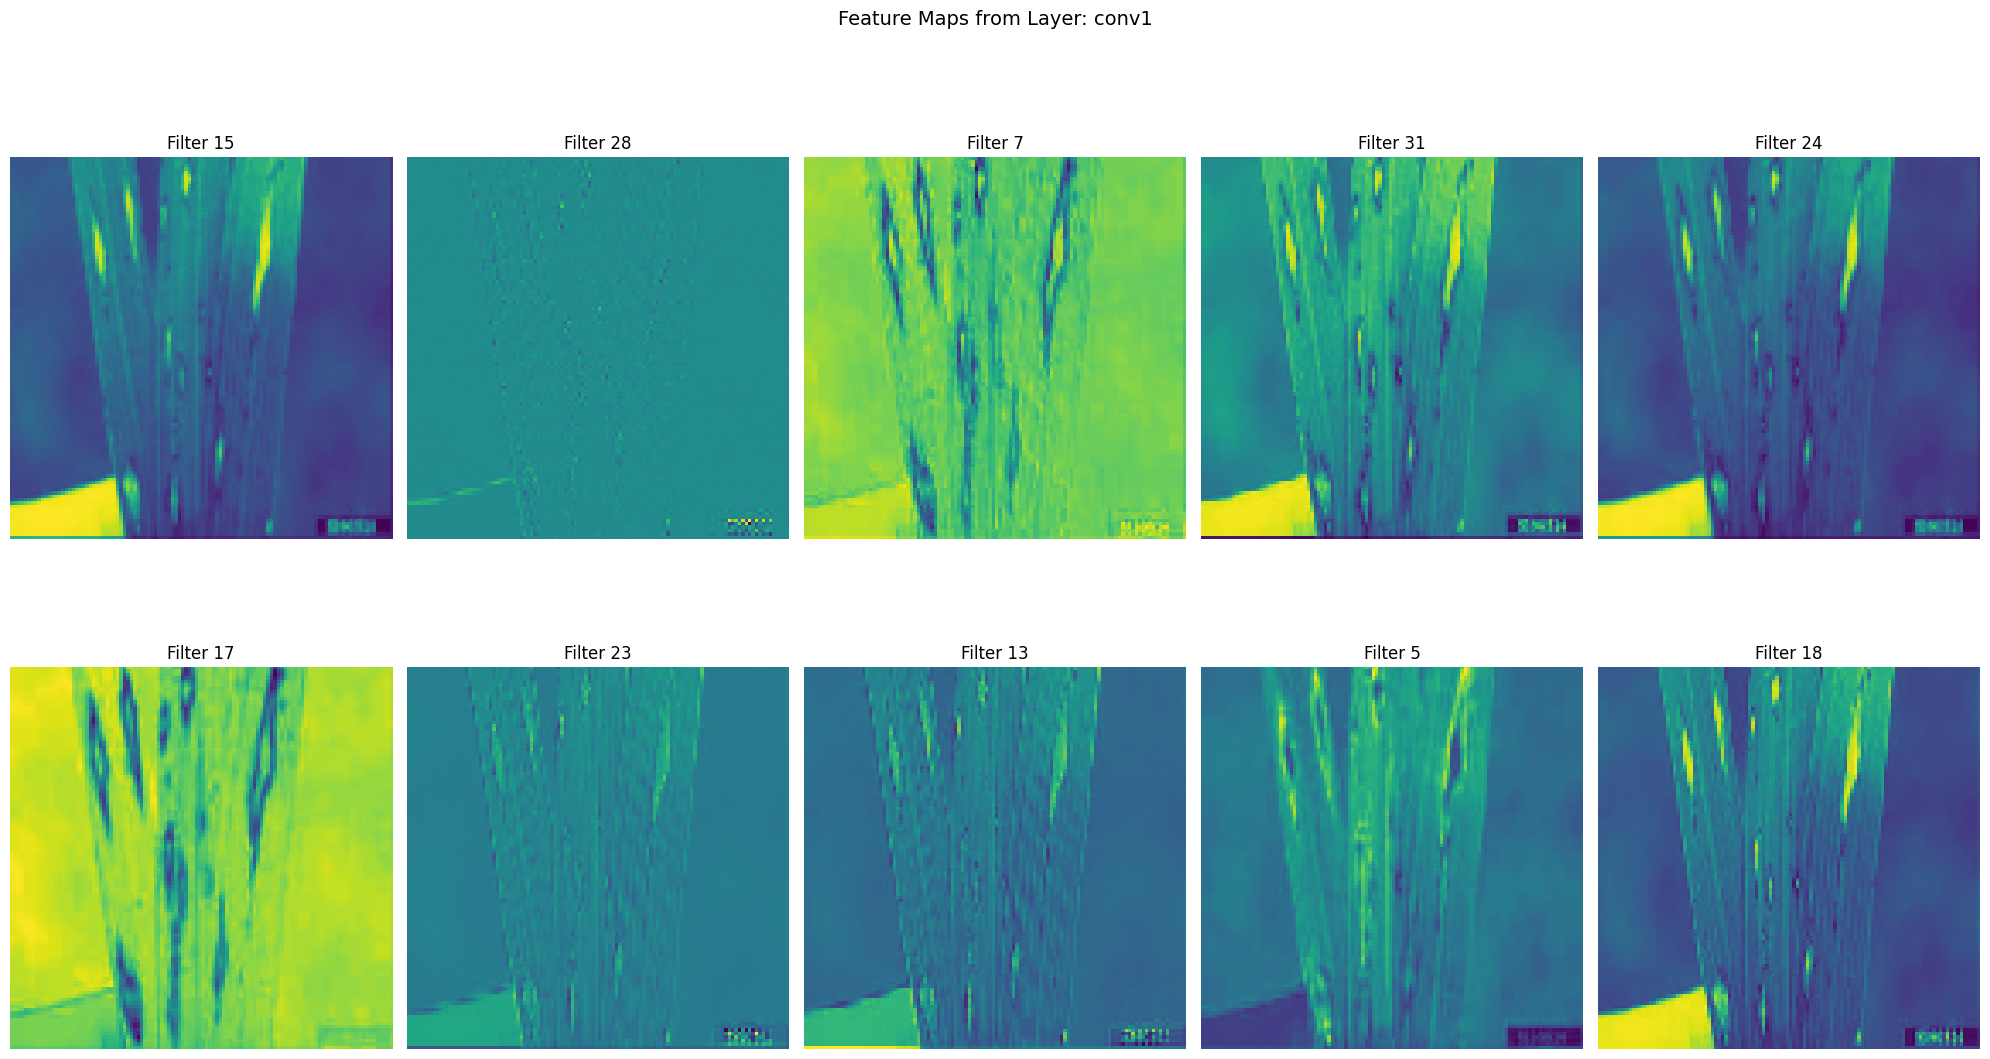

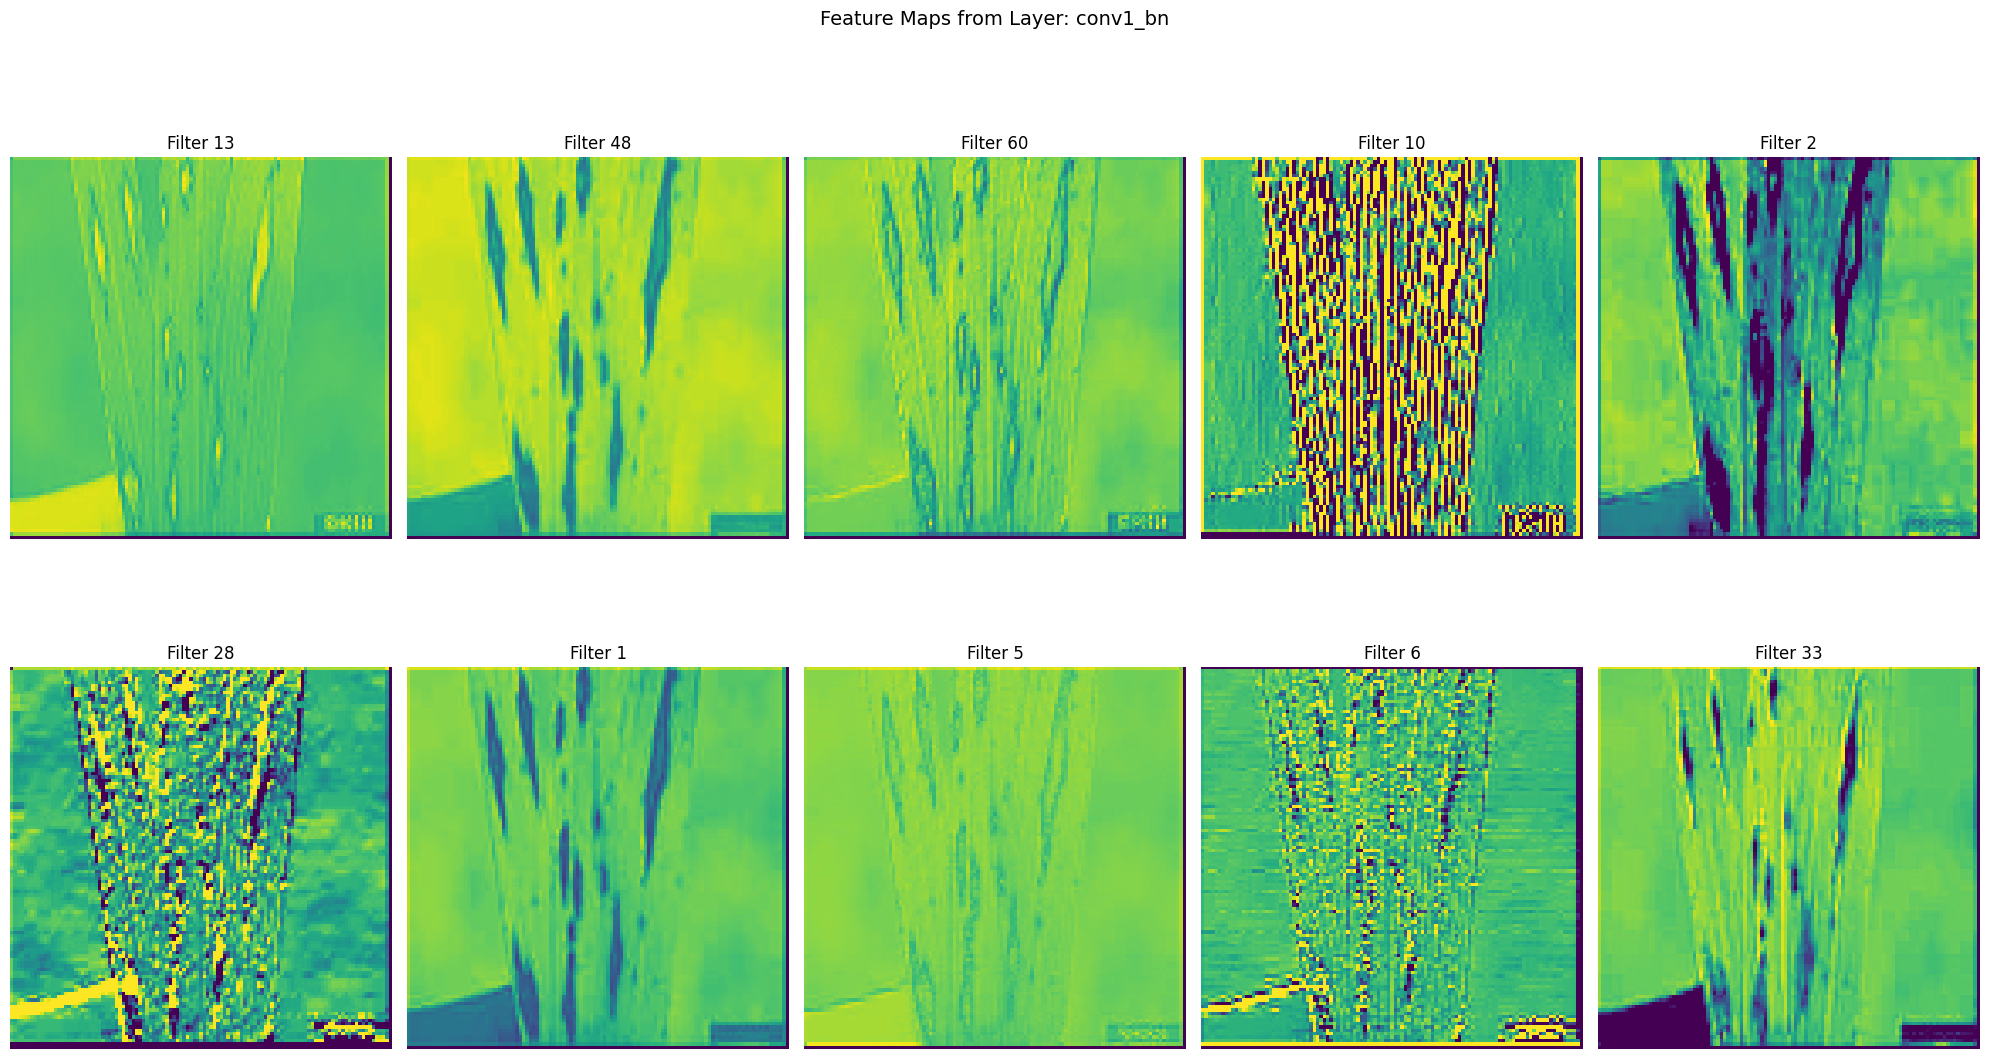

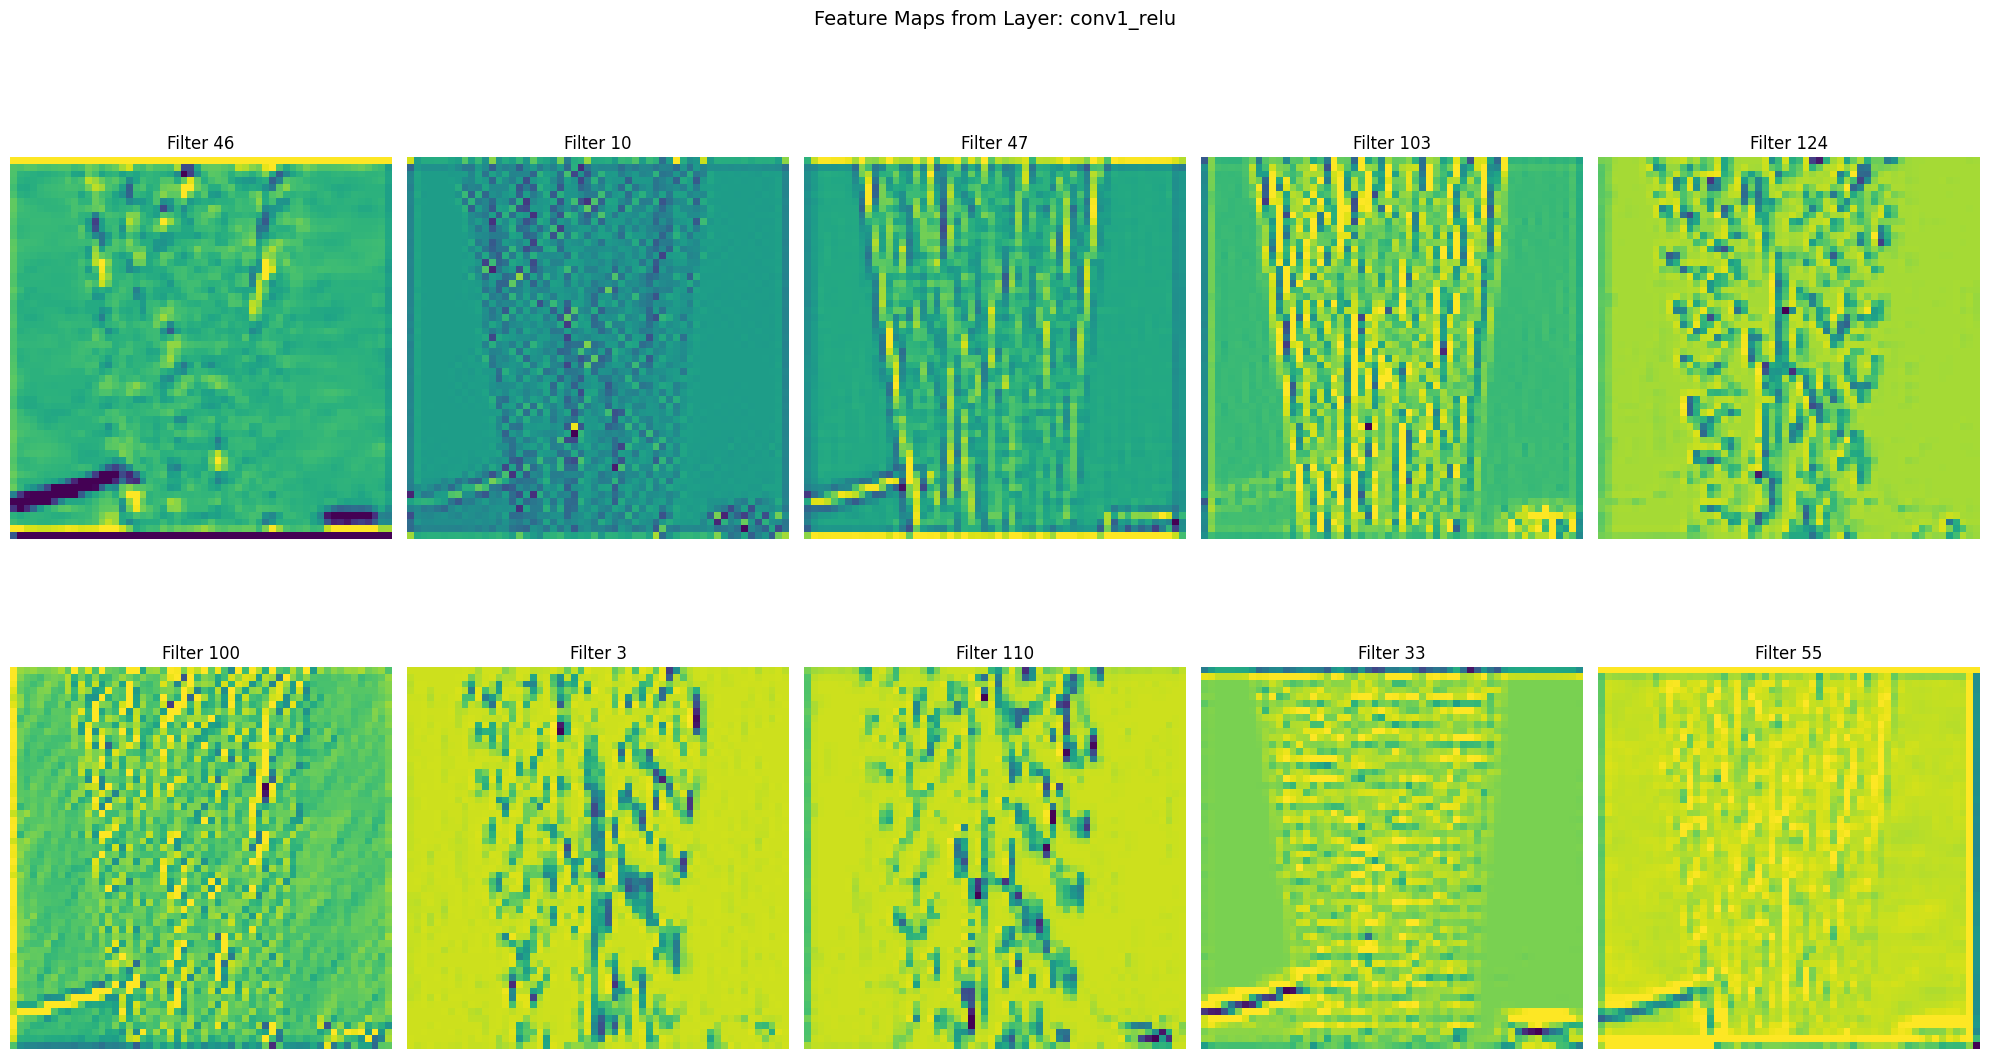

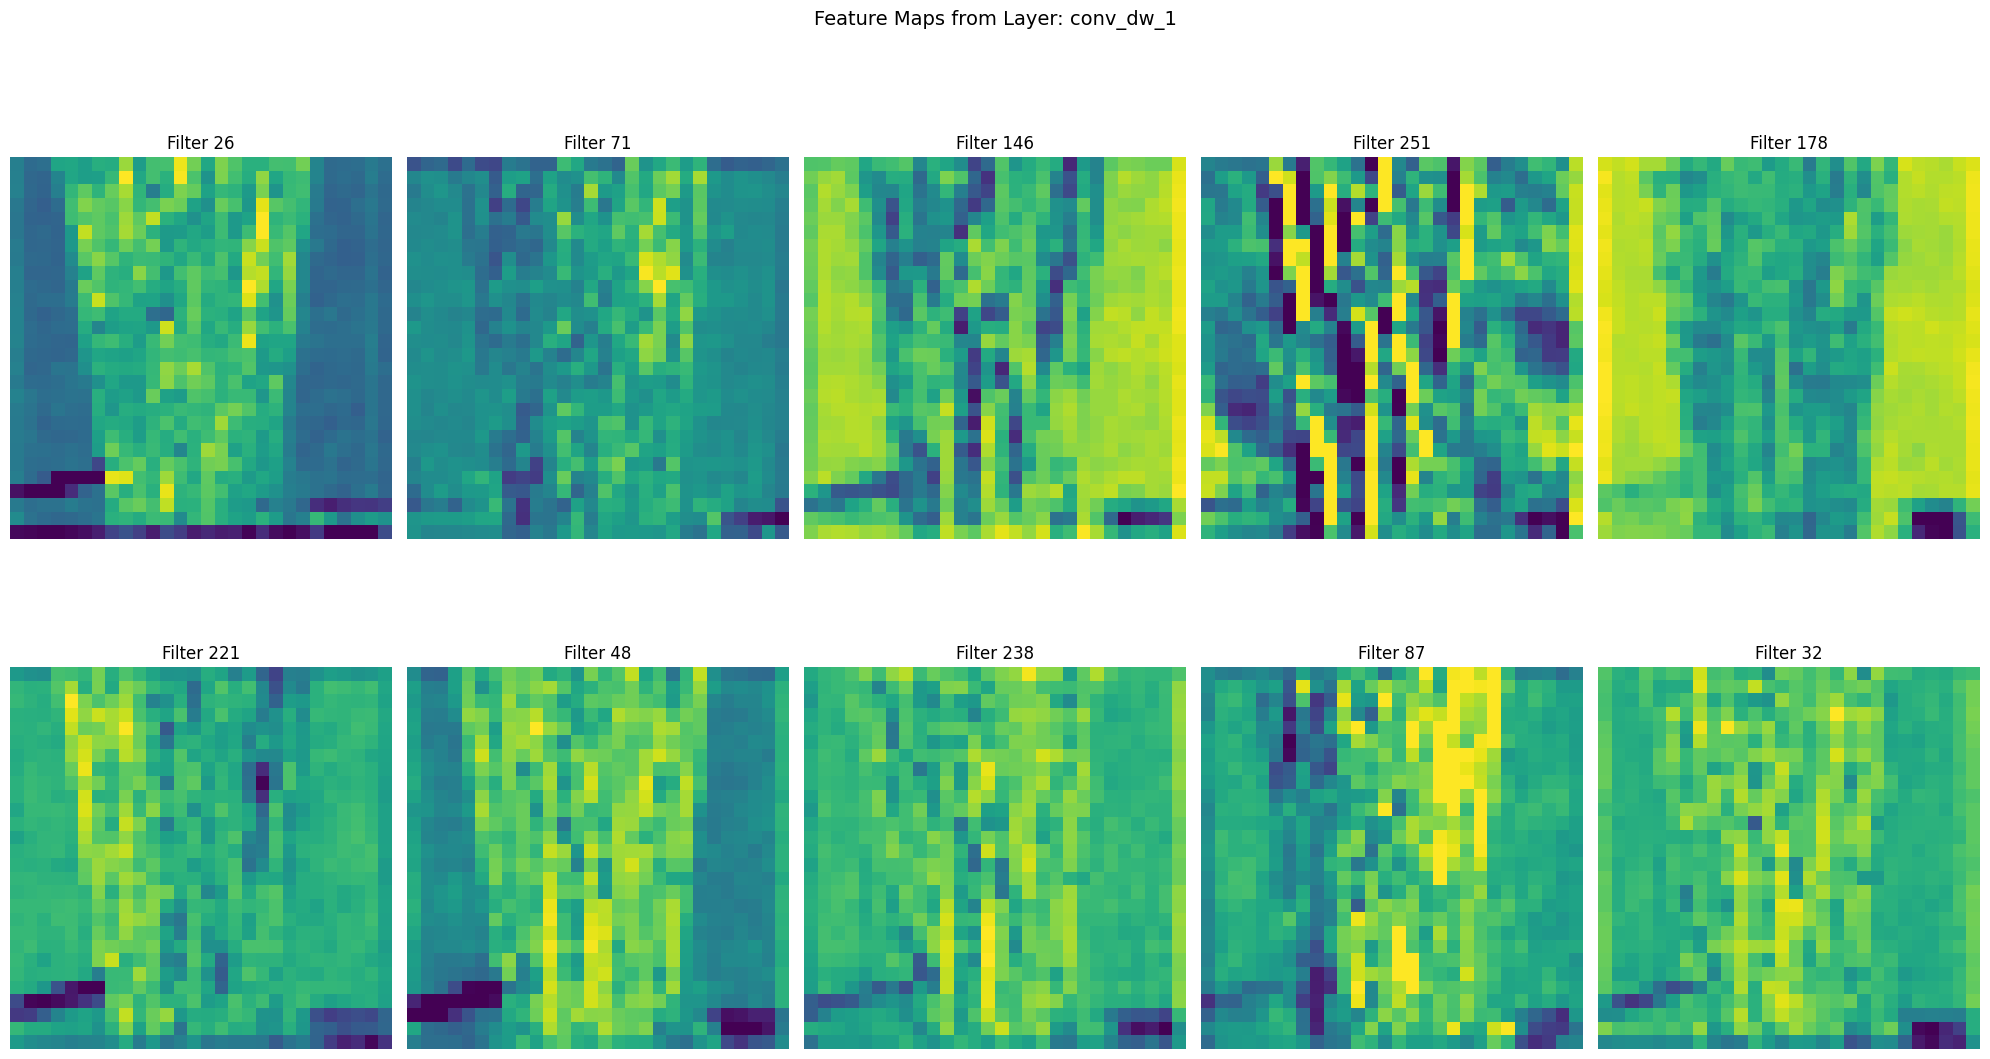

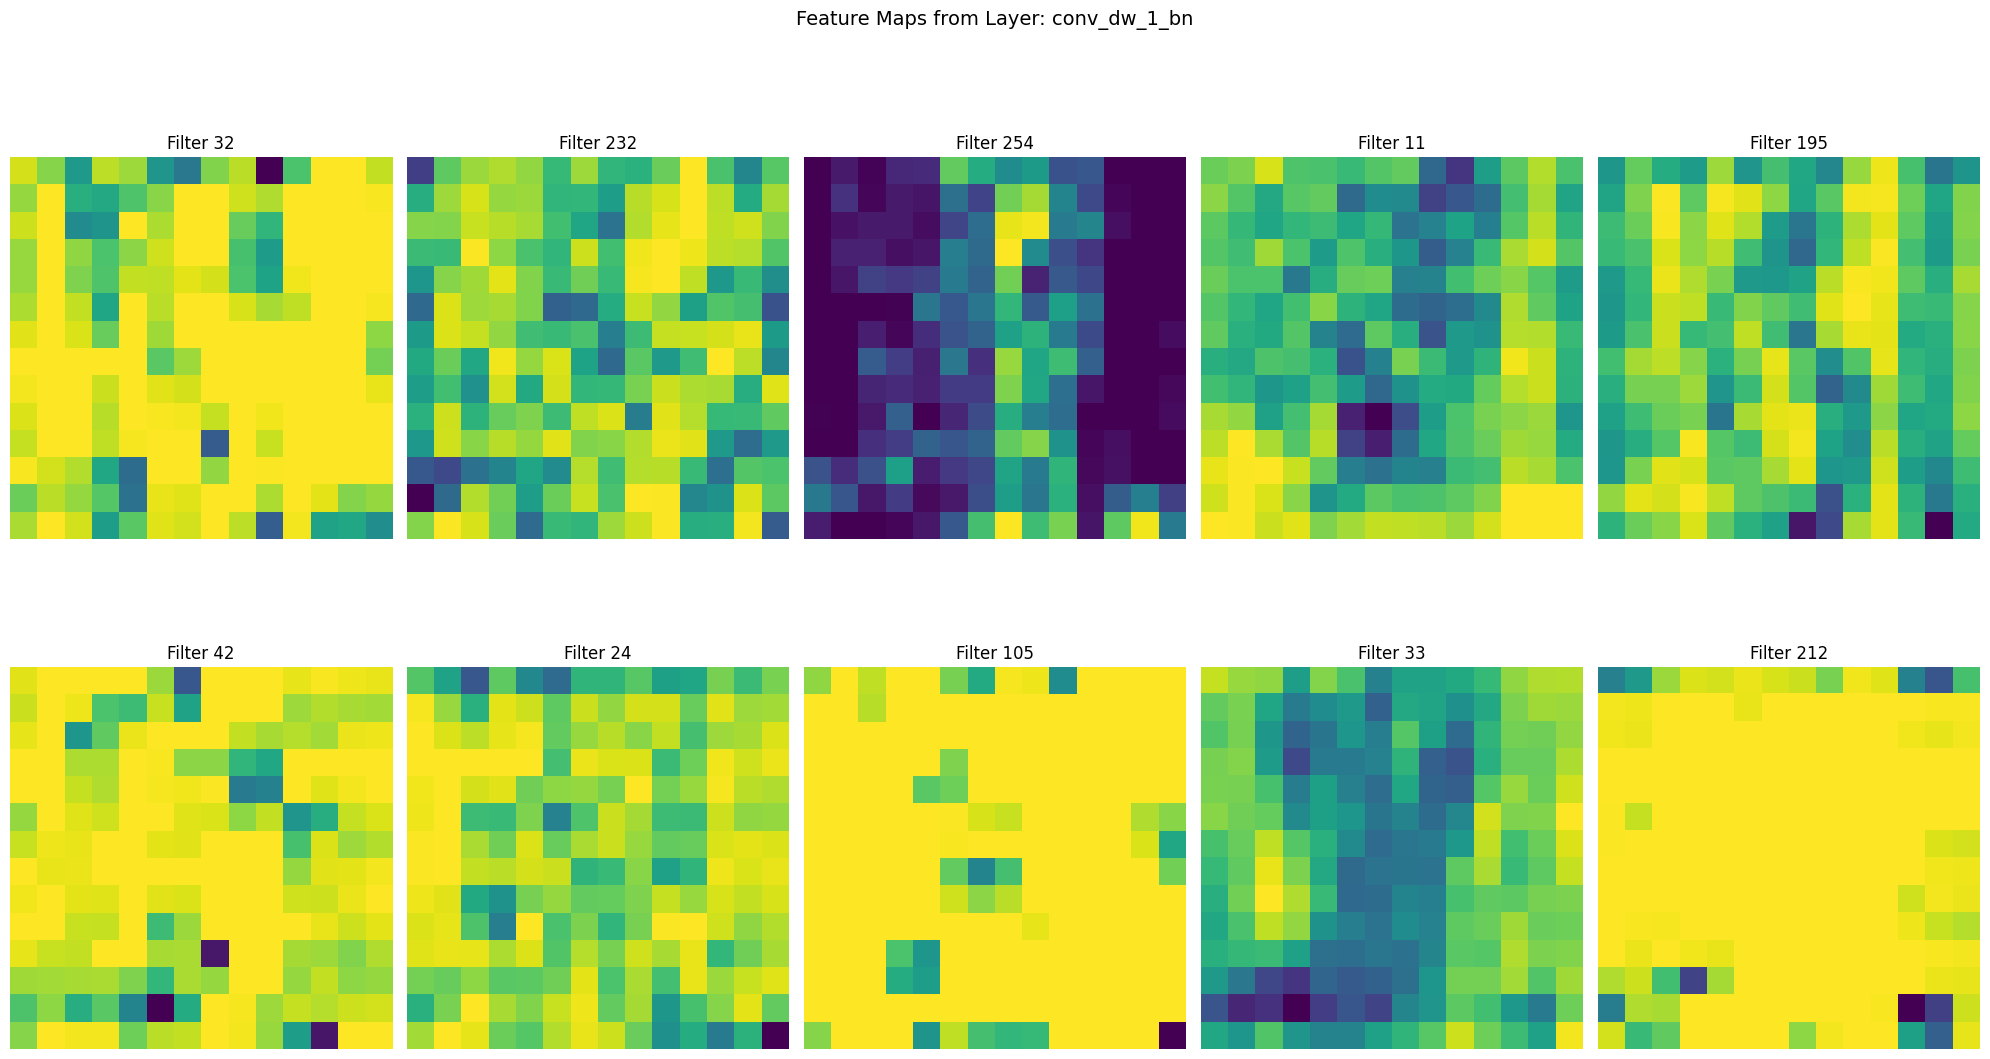

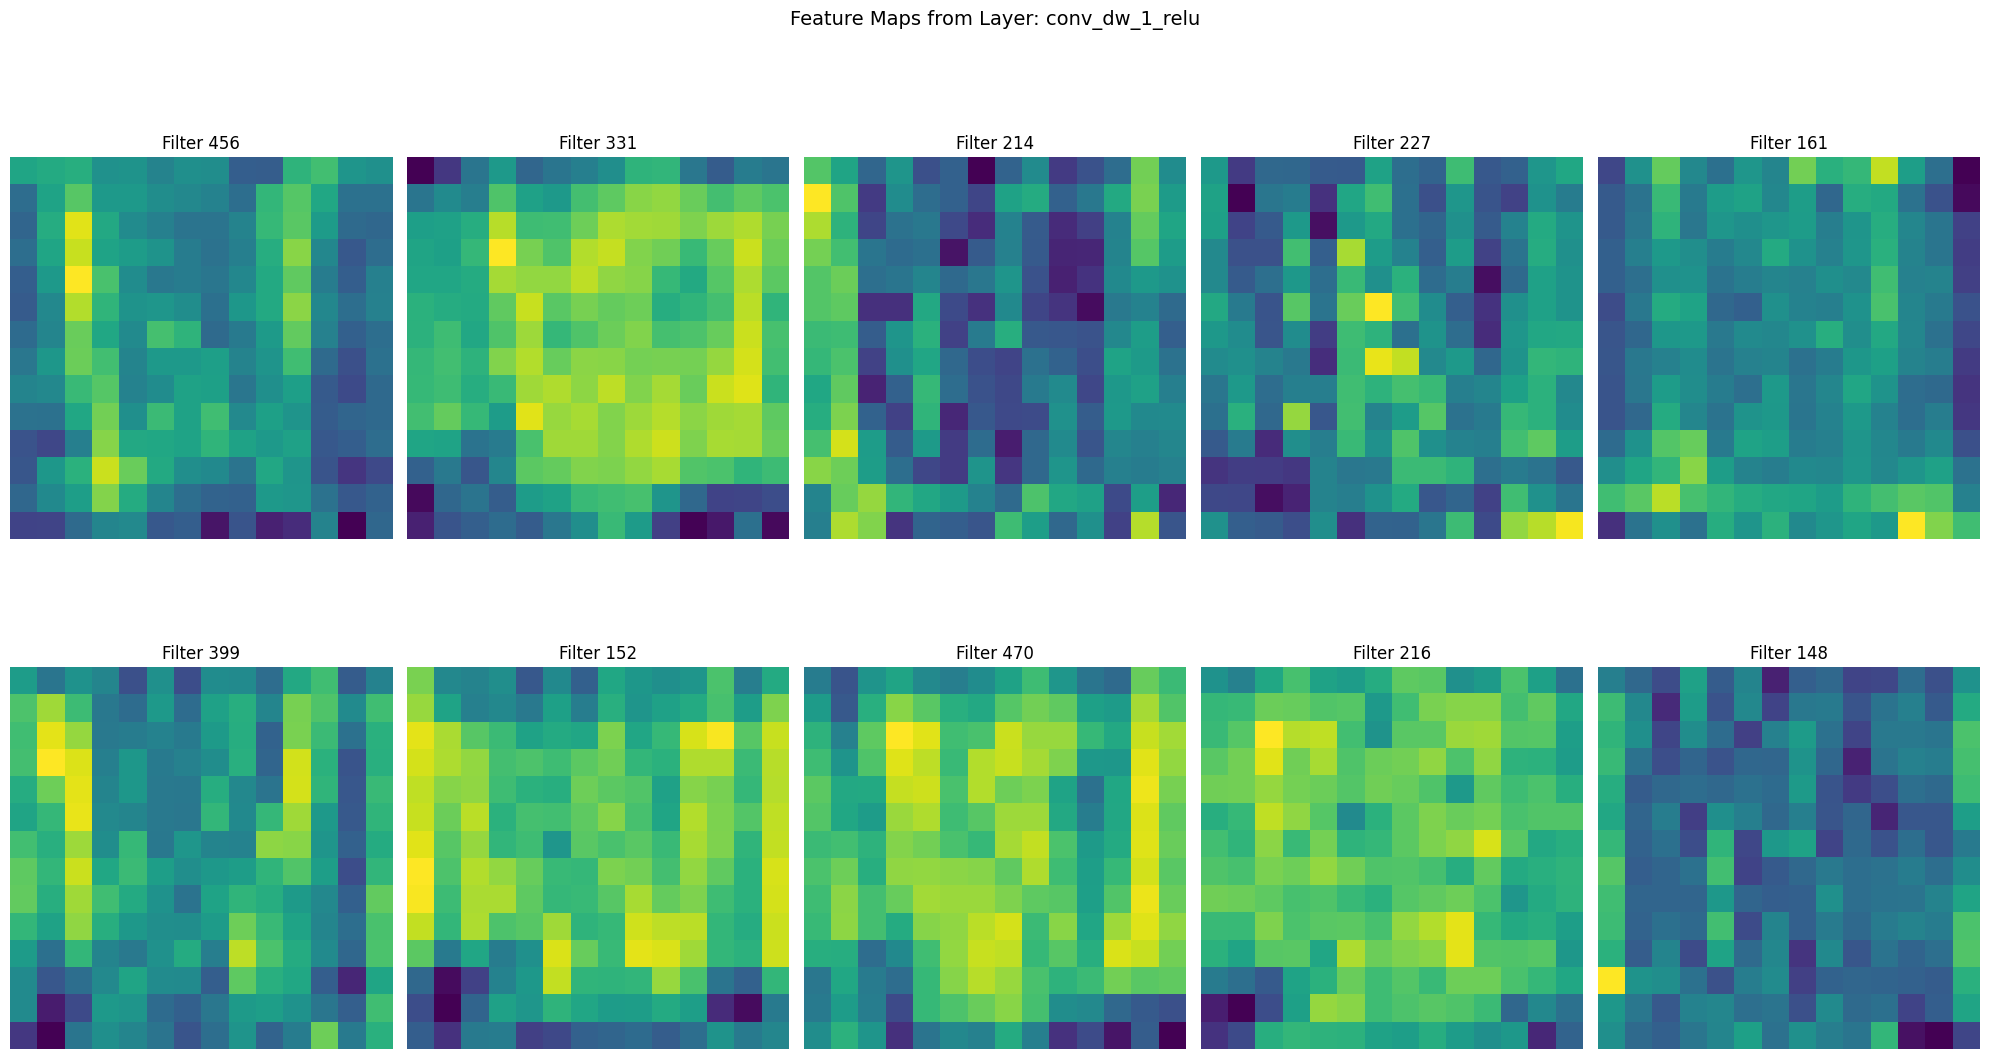

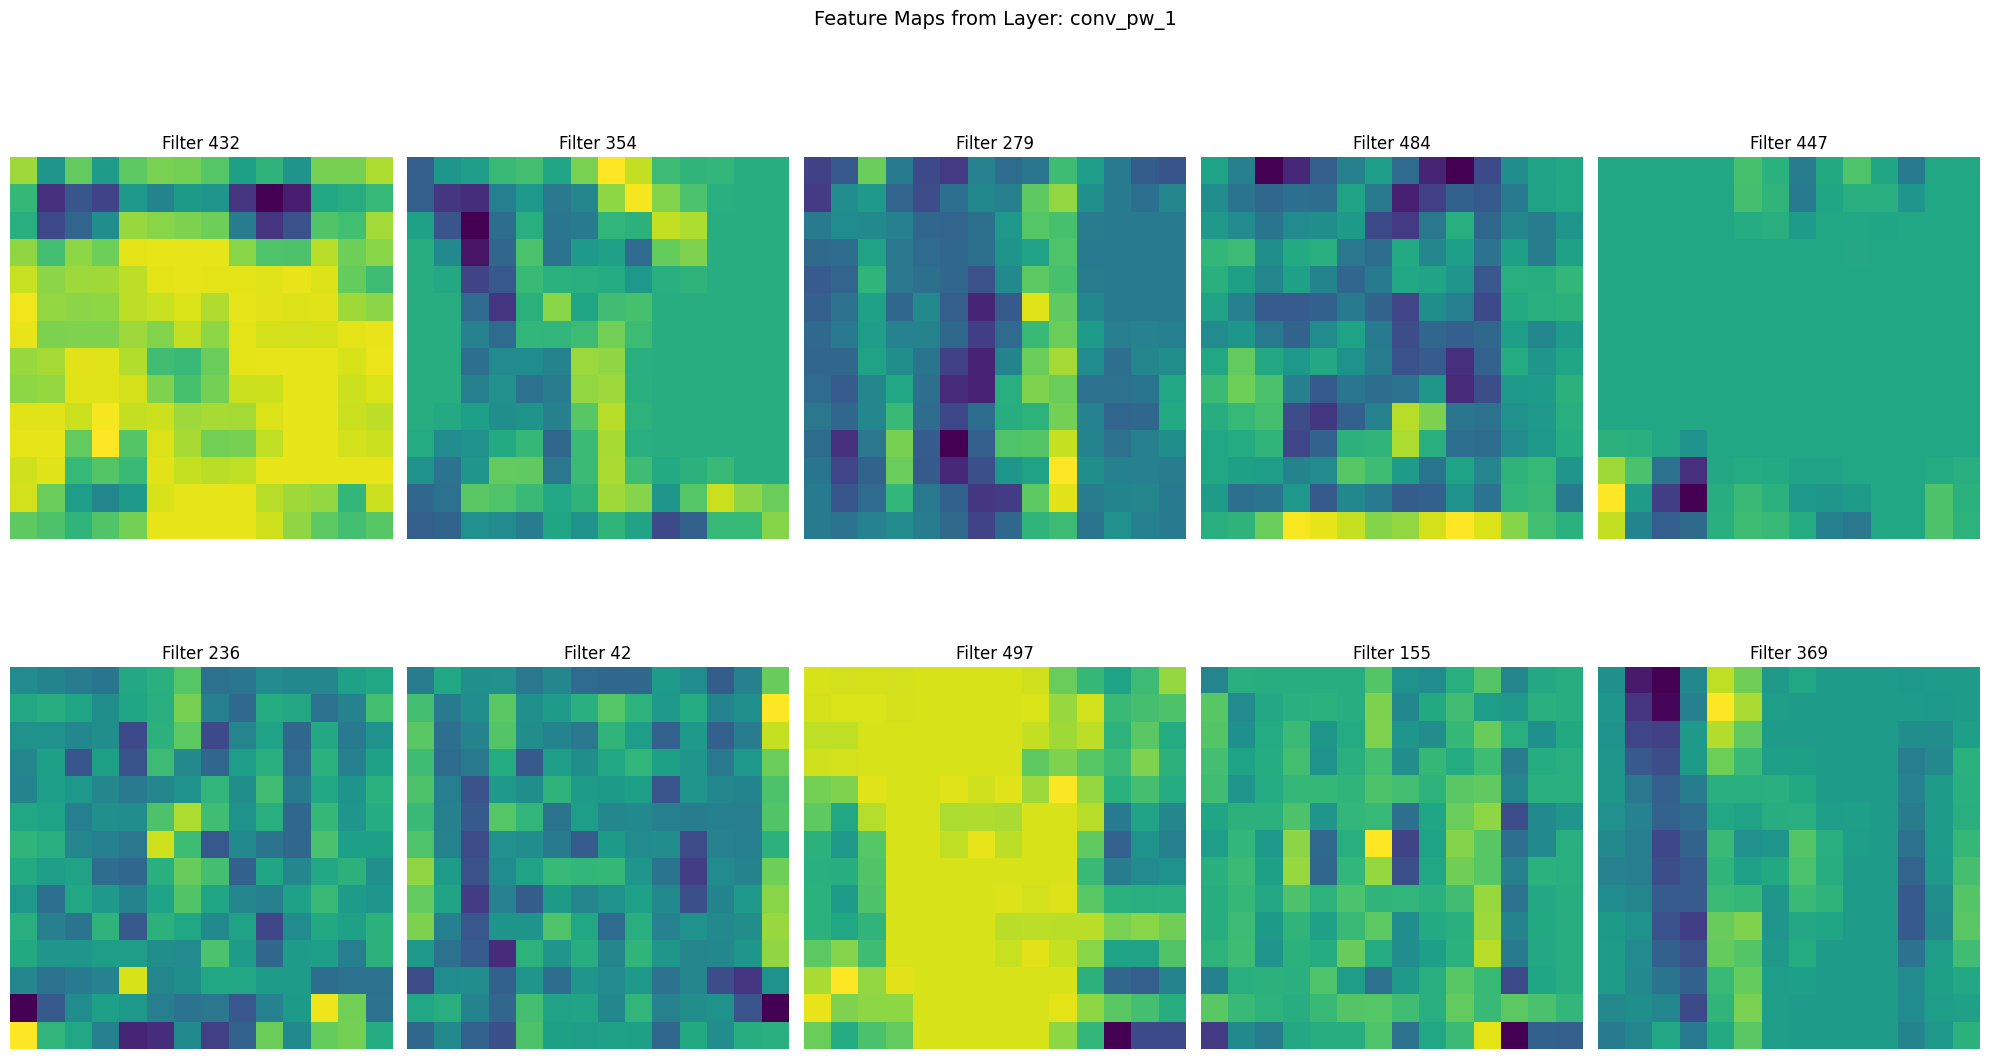

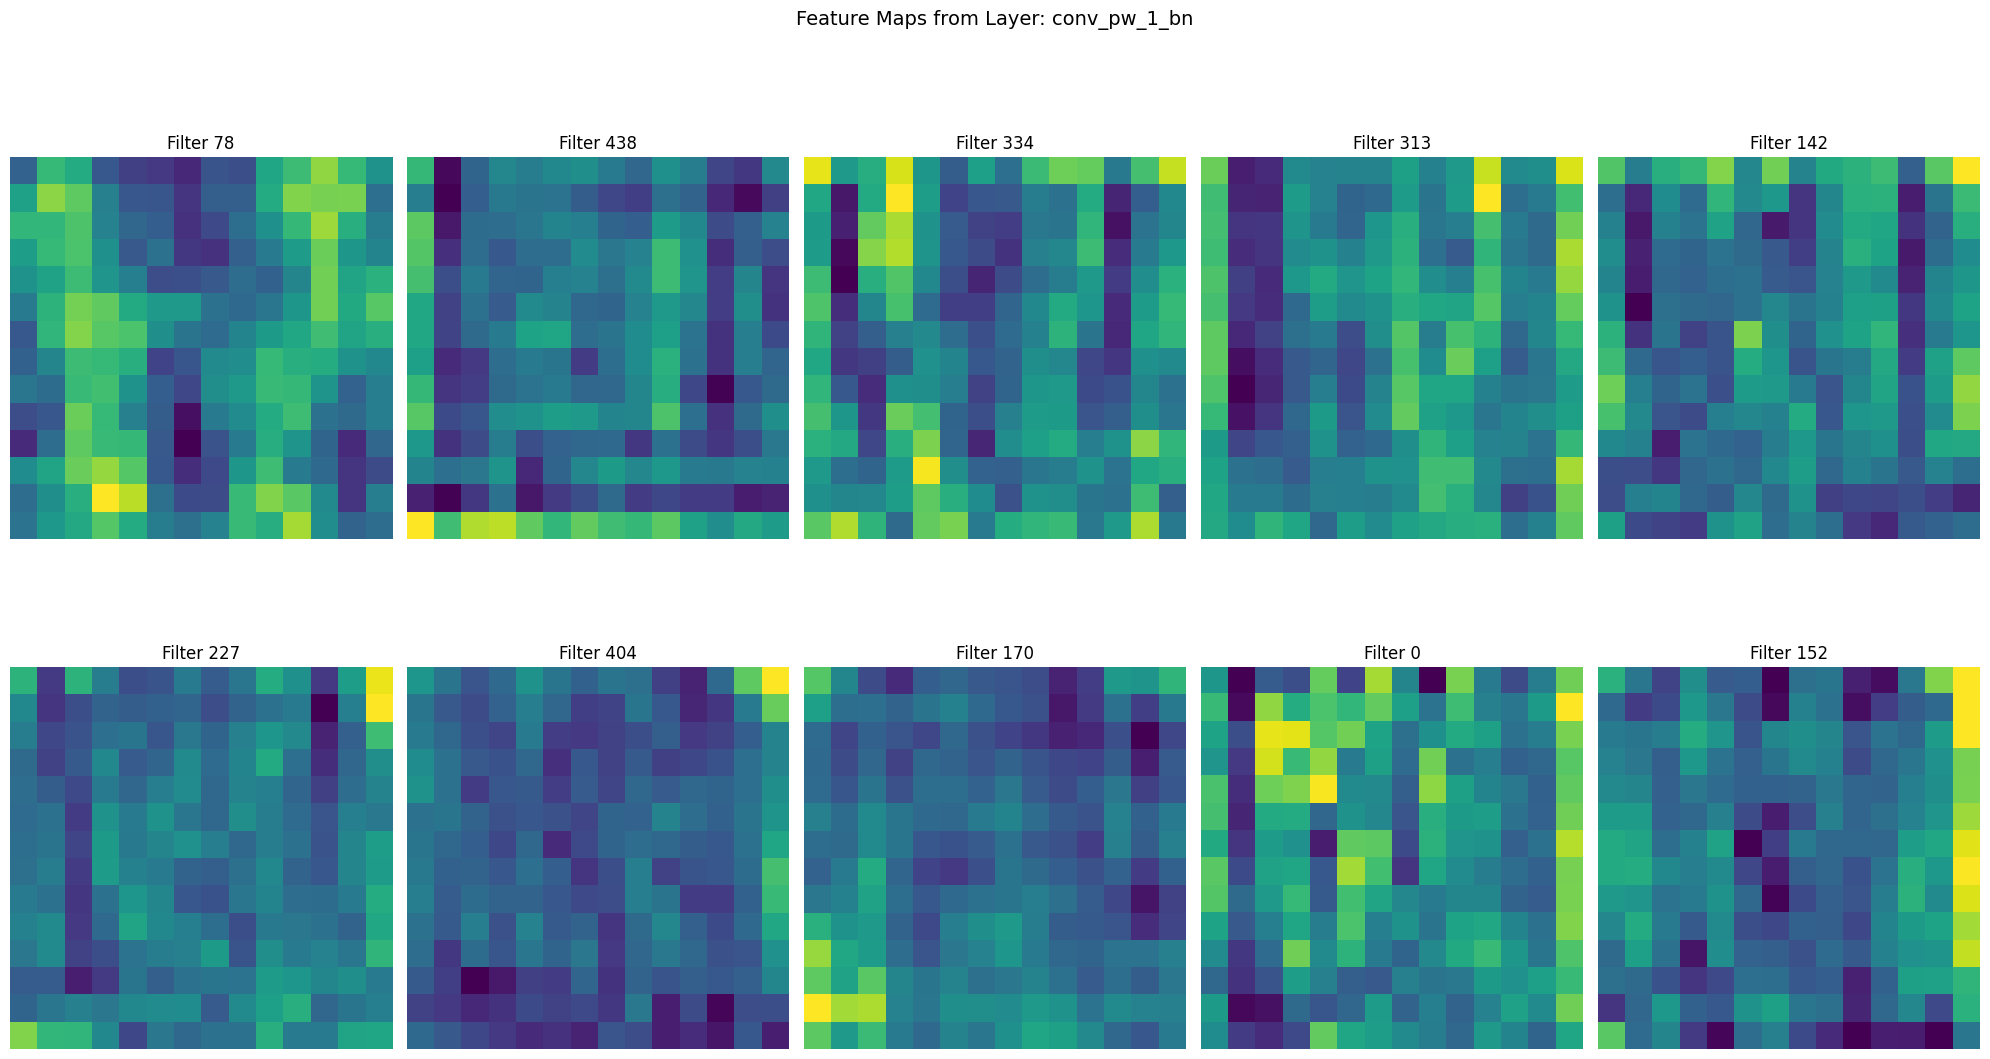

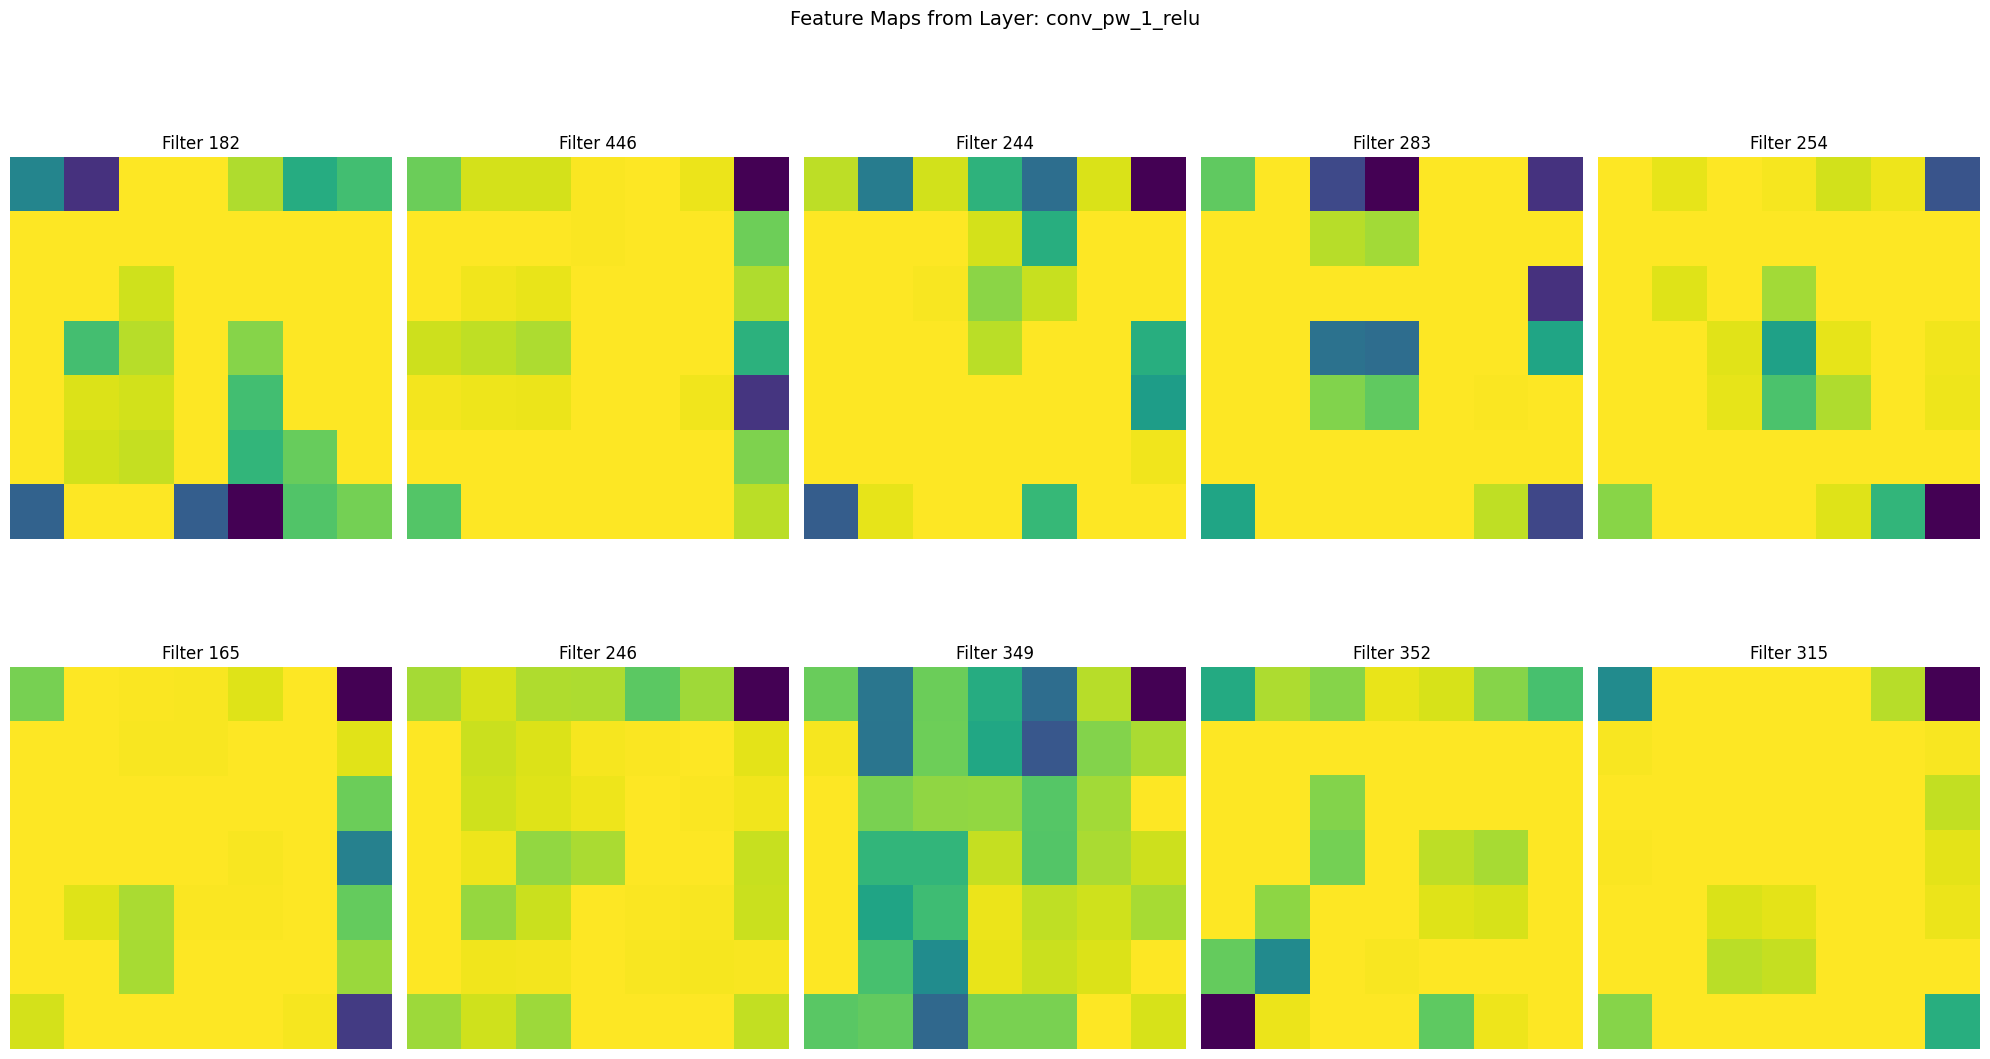

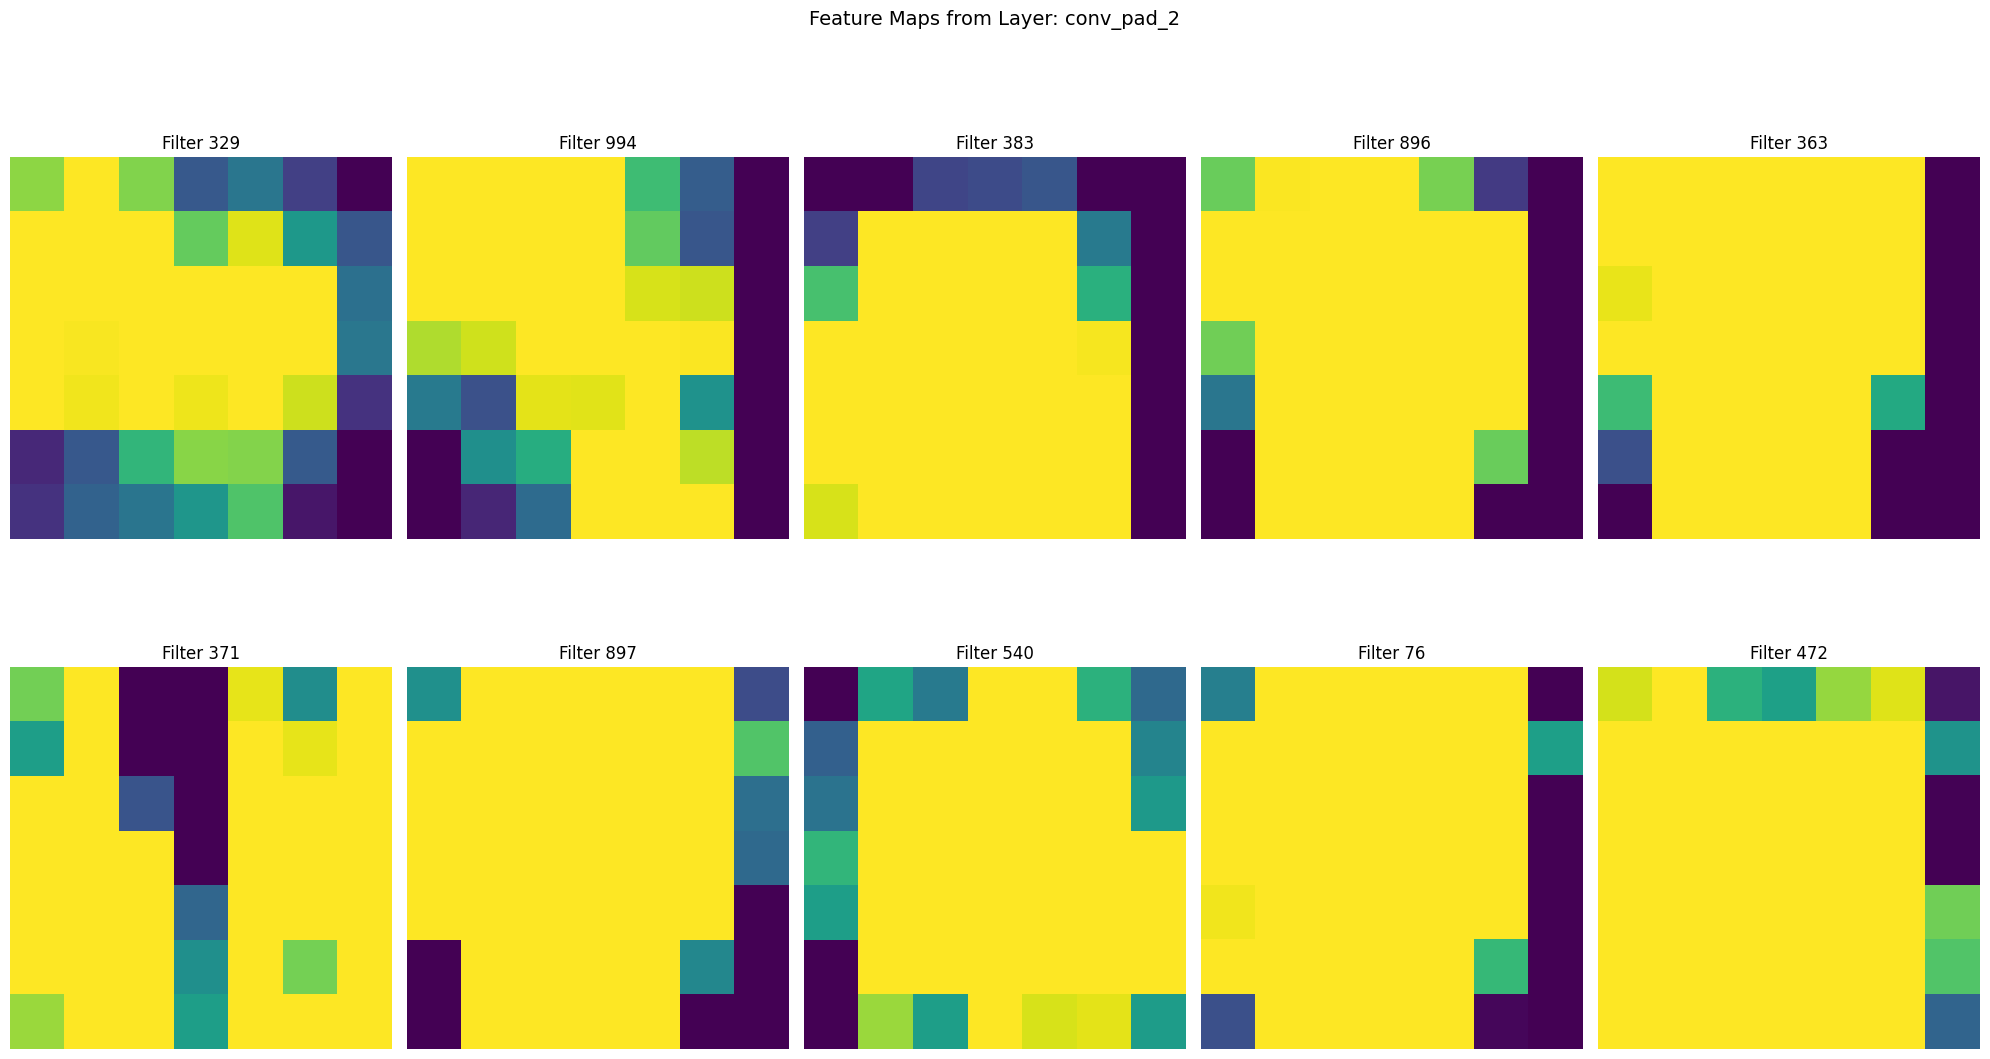

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from PIL import Image

model = tf.keras.models.load_model("crop_disease_detection_mobilenet.h5")

IMAGE_PATH = "Untitled.jpg" 

def preprocess_image(img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

def get_important_layers(model):
    important_layers = []p
    for layer in model.layers:
        if ('conv' in layer.name.lower() or 'block' in layer.name.lower()):
            try:
                output_shape = layer.output.shape
                if len(output_shape) == 4:
                    important_layers.append(layer.output)
            except:
                continue
    
    if len(important_layers) > 10:
        indices = np.linspace(0, len(important_layers)-1, 10, dtype=int)
        important_layers = [important_layers[i] for i in indices]
    
    return important_layers[:10] 

def get_layer_outputs(model, img_array):
    important_layers = get_important_layers(model)
    activation_model = Model(inputs=model.input, outputs=important_layers)
    activations = activation_model.predict(img_array)
    if not isinstance(activations, list):
        activations = [activations]
    return activations

def visualize_layer_outputs(layer_activations, model):
    important_layer_names = []
    for layer in model.layers:
        if ('conv' in layer.name.lower() or 'block' in layer.name.lower()):
            try:
                if len(layer.output.shape) == 4:
                    important_layer_names.append(layer.name)
            except:
                continue
    
    important_layer_names = important_layer_names[:10] 
    
    for layer_name, activation in zip(important_layer_names, layer_activations):
        num_filters = activation.shape[-1]
        
        plt.figure(figsize=(20, 12))
        plt.suptitle(f"Feature Maps from Layer: {layer_name}", fontsize=14)
        
        feature_maps = activation[0]
        mean_activation = np.mean(feature_maps, axis=(0, 1))
        top_indices = np.argsort(mean_activation)[-10:]
        
        for idx, filter_idx in enumerate(top_indices):
            plt.subplot(2, 5, idx + 1)
            plt.imshow(feature_maps[:, :, filter_idx], cmap='viridis')
            plt.title(f'Filter {filter_idx}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

def main():
    print(f"Using image: {IMAGE_PATH}")
    img_array = preprocess_image(IMAGE_PATH)
    
    img = Image.open(IMAGE_PATH)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    activations = get_layer_outputs(model, img_array)
    visualize_layer_outputs(activations, model)

if __name__ == "__main__":
    main()

The output shows the prediction results from your model for an image. Let's break this down:

1. **Predicted Class Index: 13**
   - Your model has identified class #13 in your list of class_labels
   - Class #13 corresponds to "Rice - Blast" in your class_labels array

2. **Predictions array**: This is the raw output from your model's final layer, showing the confidence scores (probabilities) for each of the 26 classes in your model. The significant values are:
   - Class 13 (Rice - Blast): 0.994435906 (99.44%)
   - Class 14 (Rice - Brown Spot): 0.00553540234 (0.55%)
   - Class 15 (Rice - Tungro): 0.0000265309718 (0.003%)

3. **Interpretation**: The model is extremely confident (99.44%) that the image shows Rice Blast disease. This is a fungal disease caused by Magnaporthe oryzae that creates characteristic leaf lesions on rice plants.

4. **GradCAM visualization**: Your code is generating a heatmap visualization that shows which parts of the image most influenced the model's prediction. This helps to see which areas of the leaf the model focused on to identify the disease.

Rice Blast is one of the most significant diseases affecting rice crops worldwide. It's characterized by diamond-shaped lesions with gray centers and dark borders. The high confidence score suggests that the image you provided has clear symptoms that strongly match the patterns your model learned for Rice Blast disease.

The small percentage assigned to Rice Brown Spot (0.55%) indicates there might be some visual similarities between these two rice diseases, but the model is still very confident in its primary diagnosis.

In [1]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Load pre-trained model (update model path as required)
model = tf.keras.models.load_model("crop_disease_detection_mobilenet.h5")  

# Define class labels (Ensure it matches model output classes)
class_labels = [ 'Corn - Common Rust', 'Corn - Gray Leaf Spot', 'Corn - Healthy', 'Corn - Northern Leaf Blight',
    'Potato - Bacterial Wilt', 'Potato - Early Blight', 'Potato - Healthy', 'Potato - Late Blight',
    'Potato - Nematode', 'Potato - Pests', 'Potato - Phytophthora', 'Potato - Virus',
    'Rice - Bacterial Blight', 'Rice - Blast', 'Rice - Brown Spot', 'Rice - Tungro',
    'Tomato - Bacterial Spot', 'Tomato - Early Blight', 'Tomato - Healthy', 'Tomato - Late Blight',
    'Tomato - Leaf Curl', 'Tomato - Leaf Mold', 'Tomato - Mosaic Virus', 'Tomato - Septoria Leaf Spot',
    'Tomato - Spider Mites', 'Tomato - Target Spot']

# Grad-CAM Function
def gradcam(image_path, model, layer_name, predicted_class):
    """
    Generates a Grad-CAM heatmap for the given image and model.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0].numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Apply heatmap on original image
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    heatmap_path = "gradcam_output.jpg"
    cv2.imwrite(heatmap_path, superimposed_img)

    return heatmap_path

# Prediction Function
def predict_disease(image_path):
    """
    Predicts the plant disease from the given image.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get model prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    print(f"Predicted Class Index: {predicted_class}")
    print(f"Predictions: {predictions[0]}")

    # Handle out-of-range error
    if predicted_class >= len(class_labels):
        predicted_label = "Unknown Class"
    else:
        predicted_label = class_labels[predicted_class]

    # Generate Grad-CAM heatmap
    layer_name = "conv_pw_13_relu"  # Change based on your model
    heatmap_path = gradcam(image_path, model, layer_name, predicted_class)

    return f"Predicted Disease: {predicted_label}", heatmap_path

# Gradio Interface Function
def gradio_interface(img):
    """
    Gradio function to process uploaded images and return predictions with Grad-CAM visualization.
    """
    img = np.array(img)  # Convert PIL image to NumPy array
    cv2.imwrite('temp_image.jpg', img)  # Save image temporarily
    result, heatmap_path = predict_disease('temp_image.jpg')
    return result, heatmap_path

# Create Gradio Interface
interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),
    outputs=["text", "image"],
    title="Plant Disease Detection with Grad-CAM",
    description="Upload a leaf image to detect plant disease and view the Grad-CAM heatmap."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class Index: 4
Predictions: [1.26214328e-08 4.55563480e-07 7.56333236e-08 1.35475355e-08
 7.91681349e-01 3.59978827e-07 2.04207888e-03 1.04072774e-06
 5.97662805e-03 6.79394901e-02 3.89428213e-02 9.31302384e-02
 5.66414519e-06 6.13477141e-06 1.32361947e-06 8.42490238e-07
 6.94667577e-08 1.47747833e-05 8.03339262e-08 2.53403734e-04
 2.02428168e-06 5.00798876e-07 7.66716191e-10 3.94335530e-07
 7.42639772e-09 2.59532158e-07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted Class Index: 4
Predictions: [1.26214328e-08 4.55563480e-07 7.56333236e-08 1.35475355e-08
 7.91681349e-01 3.59978827e-07 2.04207888e-03 1.04072774e-06
 5.97662805e-03 6.79394901e-02 3.89428213e-02 9.31302384e-02
 5.66414519e-06 6.13477141e-06 1.32361947e-06 8.42490238e-07
 6.94667577e-08 1.47747833e-05 8.03339262e-08 2.53403734e-04
 2.02428168e-06 5.00798876e-07 7.66716191e-10 3.94335530e-07
 7.42639772e-09 2.59532158e-07]
